In [1]:
# Importing libraries 
import json
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Creating mask function
def create_mask(image_shape, shape_attributes):
    mask = np.zeros(image_shape, dtype=np.uint8)
    
    if shape_attributes['name'] == 'polygon':
        points_x = shape_attributes['all_points_x']
        points_y = shape_attributes['all_points_y']
        points = np.array(list(zip(points_x, points_y)), dtype=np.int32)
        cv2.fillPoly(mask, [points], 1)
    
    elif shape_attributes['name'] == 'ellipse':
        center_x = int(shape_attributes['cx'])
        center_y = int(shape_attributes['cy'])
        radius_x = int(shape_attributes['rx'])
        radius_y = int(shape_attributes['ry'])
        angle = shape_attributes.get('theta', 0) * (180.0 / np.pi)  # Convert radians to degrees
        cv2.ellipse(mask, (center_x, center_y), (radius_x, radius_y), angle, 0, 360, 1, -1)
    
    return mask

In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, json_file, root_dir, image_transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        
        try:
            with open(json_file) as f:
                self.data = json.load(f)
        except FileNotFoundError:
            raise FileNotFoundError(f"JSON file '{json_file}' not found.")

        self.image_keys = list(self.data.keys())
        print(f"Loaded {len(self.image_keys)} entries from JSON file.")
        
    def __len__(self):
        return len(self.image_keys)

    def __getitem__(self, idx):
        image_key = self.image_keys[idx]
        image_info = self.data[image_key]

        file_name = image_info['filename']
        file_path = os.path.join(self.root_dir, file_name)

        try:
            image = Image.open(file_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image '{file_name}': {e}")
            return None

        original_size = image.size  # (width, height)

        regions = image_info['regions']
        mask = np.zeros((original_size[1], original_size[0]), dtype=np.uint8)  # Initialize mask with zeros

        for region in regions:
            shape_attributes = region['shape_attributes']
            mask = np.maximum(mask, create_mask((original_size[1], original_size[0]), shape_attributes))

        mask = Image.fromarray(mask)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = transforms.ToTensor()(mask)

        return image, mask


In [4]:
# Define transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])


In [5]:
# Path to the JSON file containing annotations
root_dir = 'TRAIN'
json_file_path = os.path.join(root_dir, "annotations_train.json")

# Create dataset and dataloader for training using data from the TRAIN folder
train_dataset = BrainTumorDataset(json_file_path, root_dir, image_transform=image_transform, mask_transform=mask_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Debugging the data loading process
for i, data in enumerate(train_dataloader):
    if data is not None:
        images, masks = data
        if images is None or masks is None:
            continue  
        print(f"Batch {i}: Images shape: {images.shape}, Masks shape: {masks.shape}")


Loaded 500 entries from JSON file.
Batch 0: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 1: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 2: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 3: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 4: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 5: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 6: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 7: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 8: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 9: Images shape: torch.Size([4, 3, 224, 224]), Masks shape: torch.Size([4, 1, 224, 224])
Batch 10: Image

In [6]:
# Load the DenseNet model
densenet = models.densenet121(pretrained=True)

C:\Users\Amlan Anupam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Amlan Anupam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Amlan Anupam/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:33<00:00, 957kB/s]


In [11]:
class DenseNetSegmentation(nn.Module):
    def __init__(self, num_classes=1):
        super(DenseNetSegmentation, self).__init__()
        self.densenet = models.densenet121(pretrained=True).features
        self.conv1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.densenet(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.upsample(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNetSegmentation(num_classes=1).to(device)

In [12]:
import torch.nn.functional as F

# Define Dice loss
def dice_loss(pred, target, smooth=1.0):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)

    return 1 - dice.mean()

# Combined BCE and Dice loss
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()

    def forward(self, pred, target):
        bce = F.binary_cross_entropy_with_logits(pred, target)
        pred = torch.sigmoid(pred)
        dice = dice_loss(pred, target)
        return bce + dice

In [20]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 30
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_dataloader:
        if data is None:
            continue
        images, masks = data
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader)}")


Epoch [1/30], Loss: 0.0015361871812492609
Epoch [2/30], Loss: 0.001524063385091722
Epoch [3/30], Loss: 0.0015134704972151667
Epoch [4/30], Loss: 0.001513266825582832
Epoch [5/30], Loss: 0.0015082971528172493
Epoch [6/30], Loss: 0.0015065605975687504
Epoch [7/30], Loss: 0.0015074546984396875
Epoch [8/30], Loss: 0.0015080795255489647
Epoch [9/30], Loss: 0.001503255356568843
Epoch [10/30], Loss: 0.0015046596801839768
Epoch [11/30], Loss: 0.0015008058096282184
Epoch [12/30], Loss: 0.0015000507654622198
Epoch [13/30], Loss: 0.0014987862347625195
Epoch [14/30], Loss: 0.001497785255778581
Epoch [15/30], Loss: 0.001497695286758244
Epoch [16/30], Loss: 0.0015157458689063787
Epoch [17/30], Loss: 0.0015106833688914776
Epoch [18/30], Loss: 0.0015004788266960532
Epoch [19/30], Loss: 0.0014987619426101446
Epoch [20/30], Loss: 0.0014979793734382837
Epoch [21/30], Loss: 0.001497339075896889
Epoch [22/30], Loss: 0.0014954874236136676
Epoch [23/30], Loss: 0.0014951380458660423
Epoch [24/30], Loss: 0.001

In [21]:
# Save the model
torch.save(model.state_dict(), 'densenet_segmentation.pth')

In [22]:
# Visualization and IoU calculation functions
def calculate_iou(preds, masks, threshold=0.5):
    preds = preds > threshold
    masks = masks > threshold  # Ensure masks are binary
    intersection = (preds & masks).float().sum((1, 2))  # Intersection area
    union = (preds | masks).float().sum((1, 2))        # Union area
    iou = (intersection + 1e-6) / (union + 1e-6)       # IoU calculation
    return iou.mean().item()

def visualize_images(image, mask, prediction):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    image = image.squeeze().permute(1, 2, 0).cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()

    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(prediction, cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average IoU for the training set: 1.0000


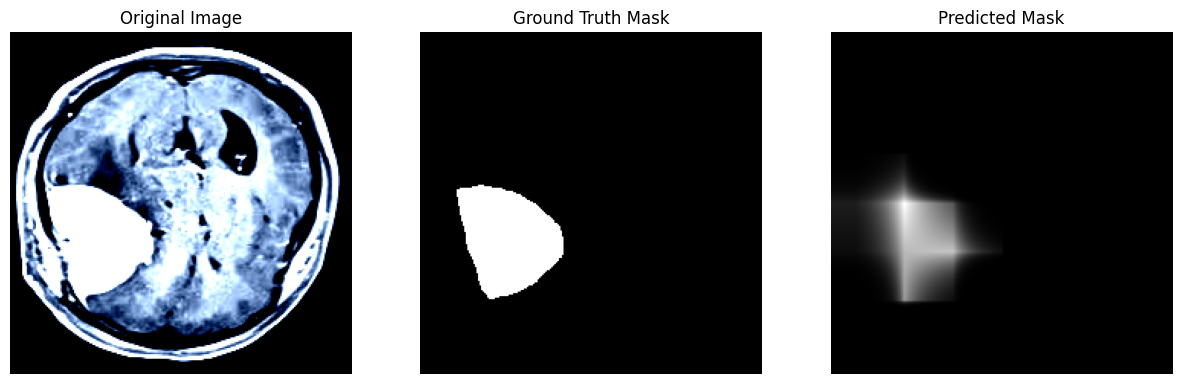

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


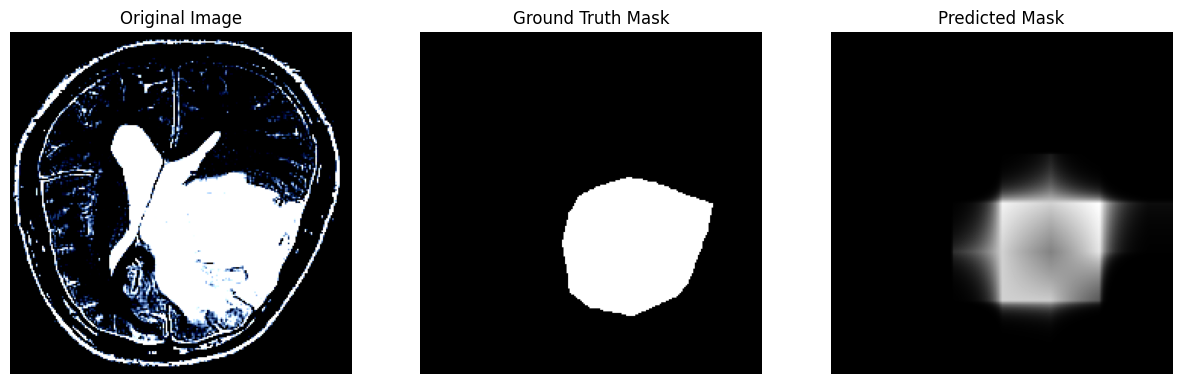

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


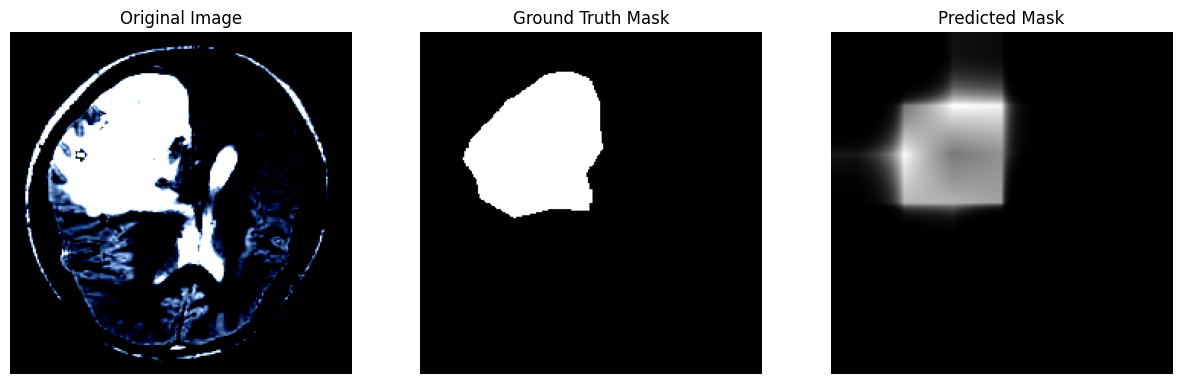

In [27]:
iou_scores_train = []

with torch.no_grad():
    model.eval()
    for images, masks in train_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        predictions = torch.sigmoid(outputs)

        for i in range(len(images)):
            iou = calculate_iou(predictions[i], masks[i])
            iou_scores_train.append(iou)

average_iou_train = sum(iou_scores_train) / len(iou_scores_train)
print(f"Average IoU for the training set: {average_iou_train:.4f}")

# Visualize some images from the training set
num_images_to_visualize_train = 3

with torch.no_grad():
    model.eval()
    for i, (image, mask) in enumerate(train_dataloader):
        if i >= num_images_to_visualize_train:
            break

        image = image.to(device)
        outputs = model(image)
        prediction = torch.sigmoid(outputs)

        visualize_images(image[0], mask[0], prediction[0])

Loaded 201 entries from JSON file.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average IoU for the validation set: 1.0000


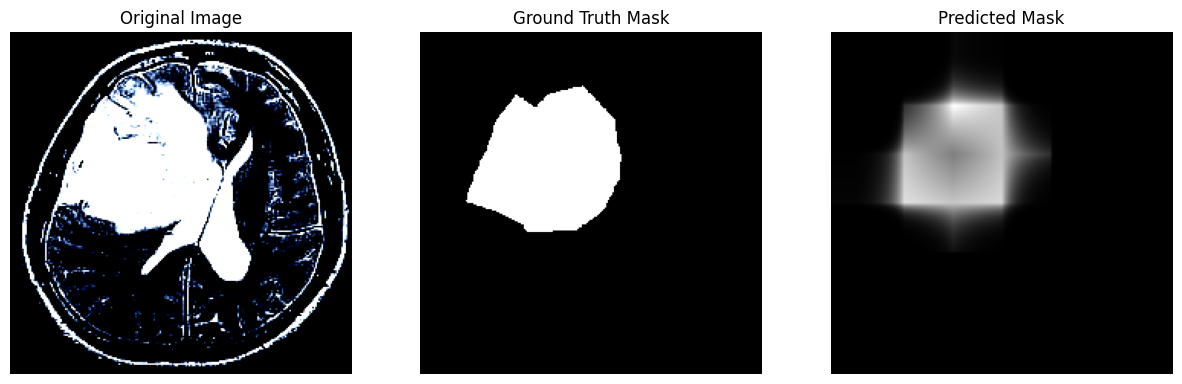

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


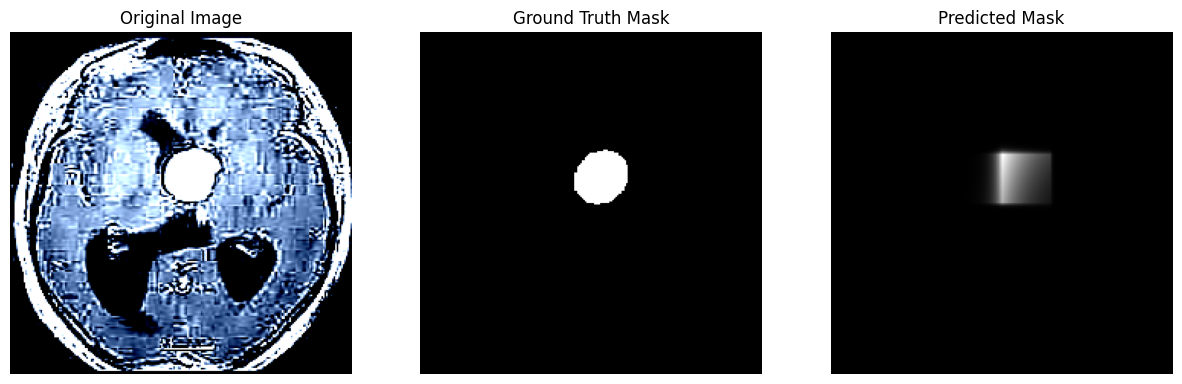

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


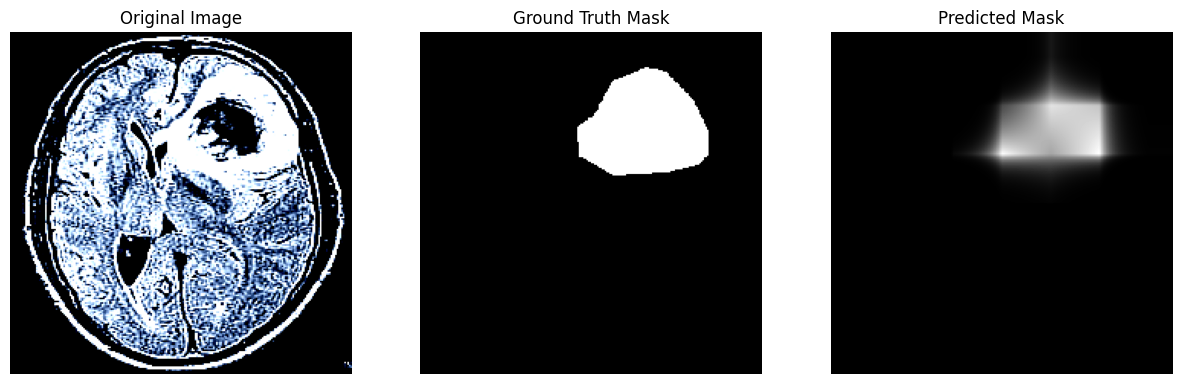

In [23]:
# Test the model and calculate IoU for the validation set
root_dir = 'VAL'
json_file_path = os.path.join(root_dir, "annotations_val.json")

val_dataset = BrainTumorDataset(json_file_path, root_dir, image_transform=image_transform, mask_transform=mask_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

iou_scores = []

with torch.no_grad():
    model.eval()
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        predictions = torch.sigmoid(outputs)

        for i in range(len(images)):
            iou = calculate_iou(predictions[i], masks[i])
            iou_scores.append(iou)

average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU for the validation set: {average_iou:.4f}")

# Visualize some images from the validation set
num_images_to_visualize = 3

with torch.no_grad():
    model.eval()
    for i, (image, mask) in enumerate(val_loader):
        if i >= num_images_to_visualize:
            break

        image = image.to(device)
        outputs = model(image)
        prediction = torch.sigmoid(outputs)

        visualize_images(image[0], mask[0], prediction[0])


Loaded 100 entries from JSON file.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average IoU for the test set: 1.0000


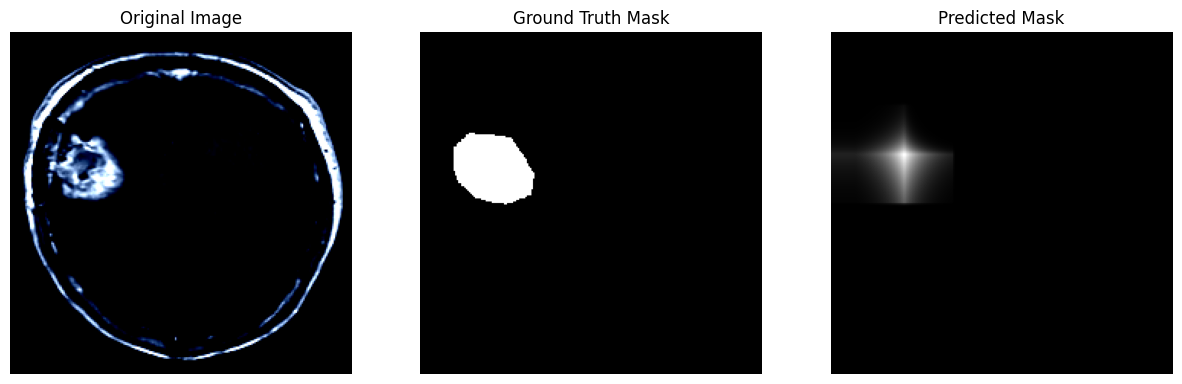

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


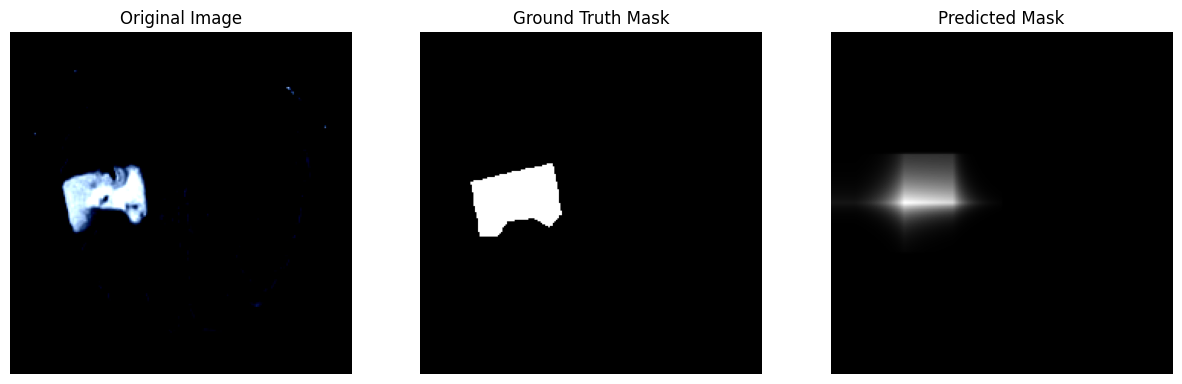

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


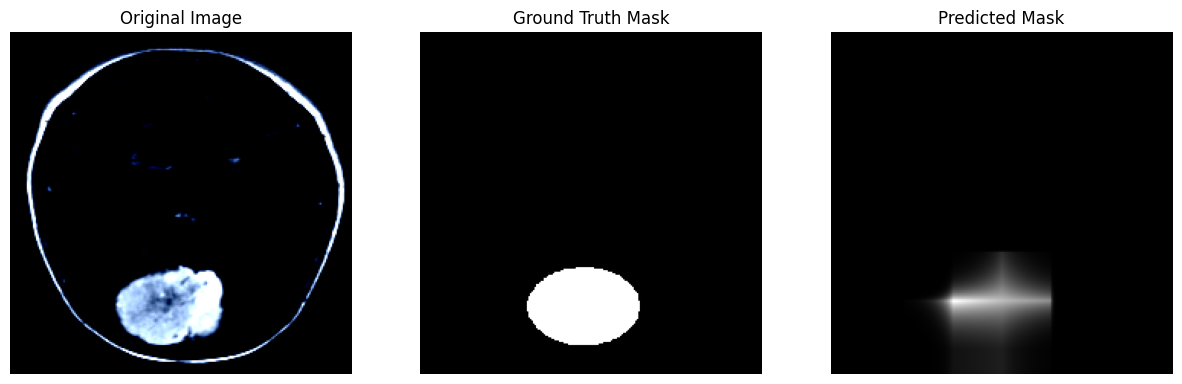

In [24]:
# Test the model and calculate IoU for the test set
root_dir = 'TEST'
json_file_path = os.path.join(root_dir, "annotations_test.json")

test_dataset = BrainTumorDataset(json_file_path, root_dir, image_transform=image_transform, mask_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

iou_scores = []

with torch.no_grad():
    model.eval()
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        predictions = torch.sigmoid(outputs)

        for i in range(len(images)):
            iou = calculate_iou(predictions[i], masks[i])
            iou_scores.append(iou)

average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU for the test set: {average_iou:.4f}")

# Visualize some images from the test set
num_images_to_visualize = 3

with torch.no_grad():
    model.eval()
    for i, (image, mask) in enumerate(test_loader):
        if i >= num_images_to_visualize:
            break

        image = image.to(device)
        outputs = model(image)
        prediction = torch.sigmoid(outputs)

        visualize_images(image[0], mask[0], prediction[0])